# Lista 03 - Aprendizado Profundo
# Lorenzo Carneiro Magalhaes - 2021031505

In [1]:
import subprocess
import zipfile
import os
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
import glob  
from PIL import Image
from tqdm import tqdm
import json

# Variables

In [2]:
TRAIN_MODEL = False
DOWNLOAD_DATA = False

In [3]:
if DOWNLOAD_DATA:
    zip_path = './anime-sketch-colorization-pair.zip'
    extract_path = './'

    subprocess.run([
        "curl", "-L", "-o", os.path.expanduser(zip_path),
        "https://www.kaggle.com/api/v1/datasets/download/ktaebum/anime-sketch-colorization-pair"
    ])

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        
    os.removedirs('data/data')
    os.removedirs('data/colorgram')


# Datasets and Dataloaders

In [4]:
TRAIN_IMGS_PATH = 'data/train/'
VALID_IMGS_PATH = 'data/val/'

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Resize((256, 512)),  
    transforms.Normalize(0.5, 0.5)  
])

class AnimeDataset(data.Dataset):
    def __init__(self, imgs_path):
        self.imgs_path = imgs_path

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert('RGB')
        pil_img = transform(pil_img)
        w = pil_img.size(2) // 2  # Split the image into two halves
        input_img = pil_img[:, :, w:]  # Right half
        target_img = pil_img[:, :, :w]  # Left half
        return input_img, target_img

    def __len__(self):
        return len(self.imgs_path)

batchsize = 128

train_imgs_path = glob.glob(f'{TRAIN_IMGS_PATH}/*.png') 
train_dataset = AnimeDataset(train_imgs_path)

valid_imgs_path = glob.glob(f'{VALID_IMGS_PATH}/*.png') 
valid_dataset = AnimeDataset(valid_imgs_path)

train_dataloader = data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=batchsize, shuffle=True, pin_memory=True)

# Model


## Downsample and Upsample

In [5]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(  
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True), 
        )
        self.bn = nn.BatchNorm2d(out_channels)

    
    def forward(self, x, is_bn=True):
        x = self.conv_relu(x)  
        if is_bn:  
            x = self.bn(x)
        return x
    

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upconv_relu = nn.Sequential( 
            nn.ConvTranspose2d(in_channels, out_channels,  
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.LeakyReLU(inplace=True),  
        )
        self.bn = nn.BatchNorm2d(out_channels)

   
    def forward(self, x, is_drop=False):
        x = self.upconv_relu(x)  
        x = self.bn(x)  
        if is_drop:  
            x = F.dropout2d(x)
        return x

## Generator

In [6]:
class Generator(nn.Module):  
    def __init__(self):
        super(Generator, self).__init__()
        
        self.down1 = Downsample(3, 64)  
        self.down2 = Downsample(64, 128)  
        self.down3 = Downsample(128, 256) 
        self.down4 = Downsample(256, 512)  
        self.down5 = Downsample(512, 512)  
        self.down6 = Downsample(512, 512) 

       
        self.up1 = Upsample(512, 512)  
       
        self.up2 = Upsample(1024, 512) 
        self.up3 = Upsample(1024, 256)  
        self.up4 = Upsample(512, 128)  
        self.up5 = Upsample(256, 64)  

        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1)

    def forward(self, x):  
        
        x1 = self.down1(x)  
        x2 = self.down2(x1)  
        x3 = self.down3(x2) 
        x4 = self.down4(x3)  
        x5 = self.down5(x4) 
        x6 = self.down6(x5)  
       
      
        x6 = self.up1(x6, is_drop=True) 
        x6 = torch.cat([x6, x5], dim=1)  

        x6 = self.up2(x6, is_drop=True)  
        x6 = torch.cat([x6, x4], dim=1)  

        x6 = self.up3(x6, is_drop=True) 
        x6 = torch.cat([x6, x3], dim=1) 

      
        x6 = self.up4(x6) 
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.up5(x6)  
        x6 = torch.cat([x6, x1], dim=1)  
       
        x = torch.tanh(self.last(x6))  
        return x

## Discriminator

In [7]:
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
      
        self.down1 = Downsample(6, 64) 
        self.down2 = Downsample(64, 128)  
        self.cov1 = nn.Conv2d(128, 256, kernel_size=3)  
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256, 1, kernel_size=3)  

    def forward(self, img, mask):  
        x = torch.cat([img, mask], dim=1)  
        x = self.down1(x, is_bn=False)  
        x = self.down2(x)
        x = F.dropout2d(self.bn(F.leaky_relu(self.cov1(x)))) 
        x = torch.sigmoid(self.last(x))
        return x

# Train with validation

## Plot function

In [8]:
def gen_img_plot(model, img, mask, epoch, save_dir='train_generated_images', n=1, save=True):  
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        output = model(img)  # [B, C, H, W]
    predictions = np.squeeze(output.permute(0, 2, 3, 1).cpu().numpy())

    # Transforma img e mask para eixo de cor no final
    img_np = img.permute(0, 2, 3, 1).cpu().numpy()
    mask_np = mask.permute(0, 2, 3, 1).cpu().numpy()

    display_list = [img_np[:n], mask_np[:n], predictions[:n]]
    titles = ['Input', 'Truth', 'Output']
    for img_idx in range(len(display_list[0])):
        plt.figure(figsize=(10, 10))
        
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(titles[i])
            # Normaliza a imagem de [-1,1] para [0,1] se estiver nessa faixa
            plt.imshow((display_list[i][img_idx] + 1) / 2)
            plt.axis('off')

        if save:
            save_path = os.path.join(save_dir, f'epoch_{epoch}.png')
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
            
        else:
            plt.show()
        
    return output, predictions

In [9]:
def train_gan(
    G, 
    D, 
    G_optim, 
    D_optim, 
    loss1,
    loss2,
    train_dataloader,
    val_dataloader,
    device, 
    LAMBDA, 
    max_epochs,
    validation=True,
    patience=10,
):
    """
    GAN training
    
    G: Generator model 
    D: Discriminator model
    G_optim: optimizer for G
    D_optim: optimizer for D
    loss1: adversarial loss
    loss2: reconstruction loss
    train_dataloader: train dataloader returning img, mask 
    val_dataloader: valid dataloader returning img, mask 
    device: torch device
    LAMBD: regularization factor
    max_epochs: max training epochs
    validation: allows validation step and early stopping
    patience=10: early stopping
    """
    # Creates the dir for logging the training data
    os.makedirs('train_log', exist_ok=True)

    # History lists to store training metrics
    D_loss_history = []
    G_loss_history = []
    D_acc_history  = []

    # History lists to store validation metrics
    val_D_loss_history = []
    val_G_loss_history = []
    val_D_acc_history  = []

    # Move models to the specified device if not already
    G.to(device)
    D.to(device)

    # Early Stopping Variables
    best_val_g_loss = float('inf')
    best_epoch      = 0
    patience_count  = 0

    # Store best models
    best_G_state = None
    best_D_state = None

    ######################################################################
    # Training Phase
    ######################################################################
    for epoch in tqdm(range(max_epochs)):
        G.train()
        D.train()

        # Train metrics: losses and discriminator acc
        train_D_epoch_loss = 0.0
        train_G_epoch_loss = 0.0
        
        train_D_epoch_acc  = 0.0
        train_D_epoch_real_acc = 0.0
        train_D_epoch_fake_acc = 0.0

        train_batch_count = len(train_dataloader)

        # imgs: b/w images
        # masks: ground truth colored images
        for imgs, masks in tqdm(train_dataloader):
            imgs  = imgs.to(device)
            masks = masks.to(device)

            #-----------------------------------------------------
            # 1) Train the Discriminator
            #-----------------------------------------------------
            D_optim.zero_grad()

            # Real pass
            D_real = D(imgs, masks) 
            D_real_loss = loss1(D_real, torch.ones_like(D_real))
            D_real_loss.backward()

            # Fake pass
            G_img    = G(imgs)
            D_fake   = D(imgs, G_img.detach())
            D_fake_loss = loss1(D_fake, torch.zeros_like(D_fake))
            D_fake_loss.backward()

            # Combine and step
            D_loss = D_real_loss + D_fake_loss
            D_optim.step()

            #-----------------------------------------------------
            # 2) Train the Generator (2 times)
            #-----------------------------------------------------
            current_G_loss = 0.0
            for _ in range(2):
                G_optim.zero_grad()

                G_img  = G(imgs)
                D_fake = D(imgs, G_img)
                
                # Adversarial loss
                G_loss_adv = loss1(D_fake, torch.ones_like(D_fake))
                
                # Reconstruction loss
                G_loss_L1  = loss2(G_img, masks)
                
                G_loss = G_loss_adv + LAMBDA * G_loss_L1
                G_loss.backward()
                G_optim.step()
                
                # Store the last loss
                current_G_loss = G_loss

            #-----------------------------------------------------
            # 3) Track Training Stats
            #-----------------------------------------------------
            train_D_epoch_loss += D_loss.item()
            train_G_epoch_loss += current_G_loss.item()

            # Discriminator accuracy
            D_real_acc = (D_real >= 0.5).float().mean().item()
            D_fake_acc = (D_fake < 0.5).float().mean().item()
            
            train_D_epoch_real_acc += D_real_acc
            train_D_epoch_fake_acc += D_fake_acc
            
            train_D_epoch_acc += (D_real_acc + D_fake_acc) / 2

        # Average over the training batches
        train_D_epoch_loss /= train_batch_count
        train_G_epoch_loss /= train_batch_count
        train_D_epoch_acc  /= train_batch_count
        
        train_D_epoch_real_acc /= train_batch_count
        train_D_epoch_fake_acc /= train_batch_count

        D_loss_history.append(train_D_epoch_loss)
        G_loss_history.append(train_G_epoch_loss)
        D_acc_history.append(train_D_epoch_acc)
        
        
        ######################################################################
        # Validation Phase
        ######################################################################
        if validation:
            
            val_D_epoch_loss = 0.0
            val_G_epoch_loss = 0.0
            val_D_epoch_acc  = 0.0
            
            G.eval()
            D.eval()

            val_batch_count = len(val_dataloader)

            with torch.no_grad():
                for imgs, masks in val_dataloader:
                    imgs  = imgs.to(device)
                    masks = masks.to(device)

                    # Discriminator on Real
                    D_real = D(imgs, masks)
                    D_real_loss = loss1(D_real, torch.ones_like(D_real))

                    # Discriminator on Fake
                    G_img  = G(imgs)
                    D_fake = D(imgs, G_img)
                    D_fake_loss = loss1(D_fake, torch.zeros_like(D_fake))

                    D_loss = D_real_loss + D_fake_loss

                    # Generator Loss
                    G_loss_adv = loss1(D_fake, torch.ones_like(D_fake))
                    G_loss_L1  = loss2(G_img, masks)
                    G_loss     = G_loss_adv + LAMBDA * G_loss_L1

                    val_D_epoch_loss += D_loss.item()
                    val_G_epoch_loss += G_loss.item()

                    # Discriminator accuracy
                    D_real_acc = (D_real >= 0.5).float().mean().item()
                    D_fake_acc = (D_fake < 0.5).float().mean().item()
                    val_D_epoch_acc += (D_real_acc + D_fake_acc) / 2

            val_D_epoch_loss /= val_batch_count
            val_G_epoch_loss /= val_batch_count
            val_D_epoch_acc  /= val_batch_count

            # Store validation stats
            val_D_loss_history.append(val_D_epoch_loss)
            val_G_loss_history.append(val_G_epoch_loss)
            val_D_acc_history.append(val_D_epoch_acc)

            # Print training and validation info
            print(
                f"[Epoch {epoch+1}/{max_epochs}] "
                f"Train - G_loss: {train_G_epoch_loss:.4f}, D_loss: {train_D_epoch_loss:.4f}, D_acc: {train_D_epoch_acc:.4f} | "
                f"Val - G_loss: {val_G_epoch_loss:.4f}, D_loss: {val_D_epoch_loss:.4f}, D_acc: {val_D_epoch_acc:.4f}"
            )

            #-------------------------------
            # Early Stopping Check
            #-------------------------------
            
            # We use G validation loss for early stopping
            
            # Improvement
            if val_G_epoch_loss < best_val_g_loss:
                best_val_g_loss = val_G_epoch_loss
                best_epoch = epoch
                patience_count = 0
                
                best_G_state = G.state_dict()
                best_D_state = D.state_dict()
                
            else:
                # No improvement
                patience_count += 1

            # If patience is exceeded, stop training
            if patience_count >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
                break

        # No validation set up
        else:
            print(
                f"[Epoch {epoch+1}/{max_epochs}] "
                f"Train - D_loss: {train_D_epoch_loss:.4f}, G_loss: {train_G_epoch_loss:.4f}, D_acc: {train_D_epoch_acc:.4f}"
            )

        #----------------------------------------------------------------------
        # Plot images at the end of each epoch
        #----------------------------------------------------------------------
        sample_imgs, sample_masks = next(iter(train_dataloader))
        sample_imgs = sample_imgs.to(device)
        sample_masks = sample_masks.to(device)
        gen_img_plot(G, sample_imgs, sample_masks, epoch)
        
        #----------------------------------------------------------------------
        # Write logs
        #----------------------------------------------------------------------
        log_dict = {
            'train_G_epoch_loss': train_G_epoch_loss,
            'train_D_epoch_loss': train_D_epoch_loss,
            'train_D_epoch_real_acc': train_D_epoch_real_acc,
            'train_D_epoch_fake_acc': train_D_epoch_fake_acc,
            'train_D_epoch_mean_acc': train_D_epoch_acc,
            
            'valid_G_loss': val_G_epoch_loss,
            'valid_D_loss': val_D_epoch_loss,
            'valid_D_acc': val_D_epoch_acc
        }
        
        train_log_file = f"train_log/train_epoch_{epoch}.json"
        with open(train_log_file, mode="w") as f:
            json.dump(log_dict, f, indent=4)

    #==========================================================================
    # Restore the model
    #==========================================================================
    if best_G_state is not None and best_D_state is not None:
        G.load_state_dict(best_G_state)
        D.load_state_dict(best_D_state)
        print(f"Loaded best model from epoch {best_epoch+1} with val G_loss={best_val_g_loss:.4f}.")

    return (G, D, best_epoch)

# Main

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)

if TRAIN_MODEL:

    G = Generator().to(device)  
    D = Discriminator().to(device)  

    G_optim = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
    D_optim = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

    loss1 = torch.nn.BCELoss()
    loss2 = torch.nn.L1Loss()
    LAMBDA = 7

    best_G, best_D, best_epoch = train_gan(
        G=G,
        D=D,
        G_optim=G_optim,
        D_optim=D_optim,
        loss1=loss1,
        loss2=loss2,
        train_dataloader=train_dataloader,
        val_dataloader=valid_dataloader,
        device=device,
        LAMBDA=LAMBDA,
        max_epochs=60,
        patience=10
    )

    best_G_state = G.state_dict()
    best_D_state = D.state_dict()

    torch.save(best_G_state, 'best_G.pth')
    torch.save(best_D_state, 'best_D.pth')

# Tests

I made the code in regular python then transfered to jupyter, then I am not going to execute and train the model again, just import the model

In [11]:
G_model = Generator()
G_state_dict = torch.load('best_G.pth', weights_only=True)
G_model.load_state_dict(G_state_dict)
G_model.to(device)

D_model = Discriminator()
D_state_dict = torch.load('best_D.pth', weights_only=True)
D_model.load_state_dict(D_state_dict)
D_model.to(device)

()

()

## Images from training

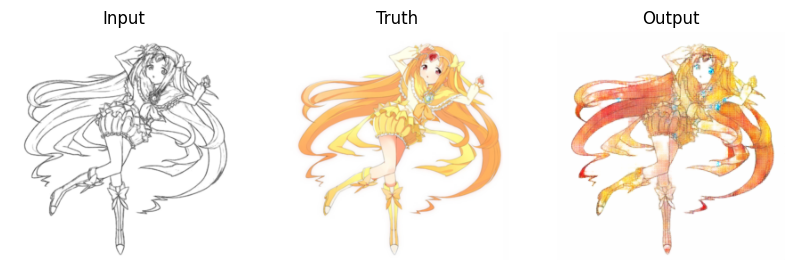

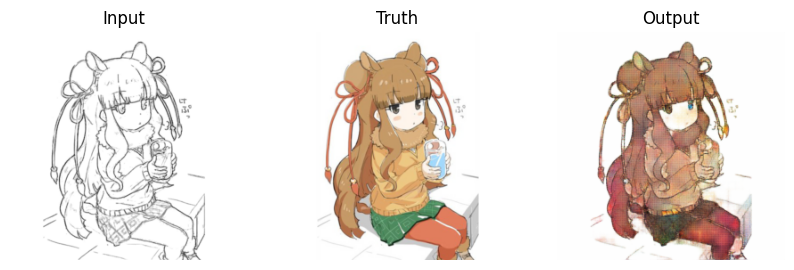

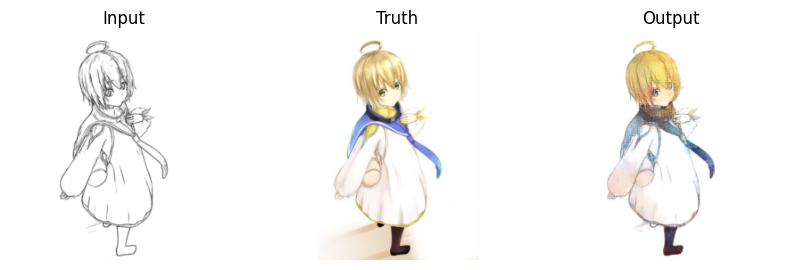

In [12]:
for i in range(3):
    image, mask = next(iter(train_dataloader))
    image = image.to(device)
    mask = mask.to(device)
    output, pred_image = gen_img_plot(G_model, image, mask, 0, save=False)

## Images from validation dataloader, never have been seen

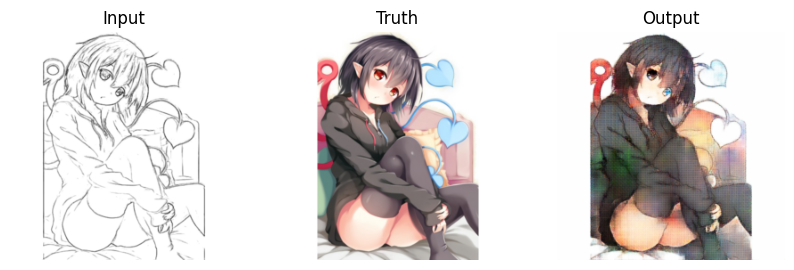

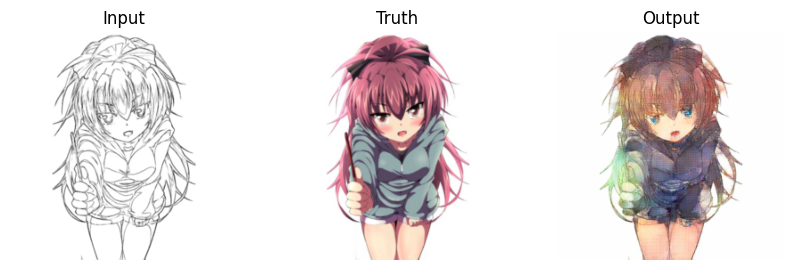

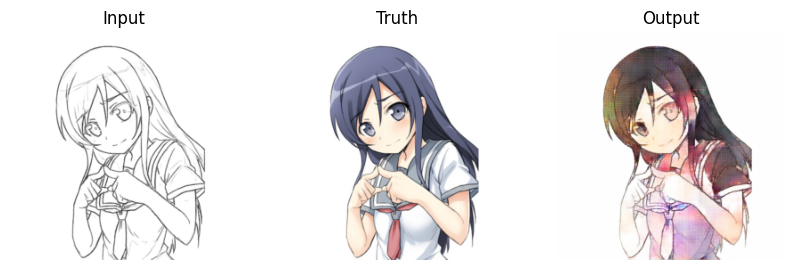

In [13]:
image, mask = next(iter(valid_dataloader))
image = image.to(device)
mask = mask.to(device)
output, pred_image = gen_img_plot(G_model, image, mask, 0, n=3, save=False)

# Considerations

The model architecture is not optimal, but it still managed to produce reasonable results

The training process is relatively slow: running 60 epochs in a RTX 3060 TI would take roughly 7 hours. However the early stopping was triggered and the model trained for 16 epochs.

Considering that the model was trained for just 16 epochs, the obtained outputs are promising.

For future work, it would be nice develop a more advanced model capable of better understanding the images and generating higher-quality outputs.